In [17]:
!git clone https://github.com/beckhamtoh/char-llm-assignment.git
%cd char-llm-assignment

Cloning into 'char-llm-assignment'...


/usr/lib/python3.11/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


remote: Enumerating objects: 24, done.
remote: Counting objects: 100% (24/24), done.
remote: Compressing objects: 100% (20/20), done.
remote: Total 24 (delta 4), reused 11 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (24/24), 30.22 MiB | 22.47 MiB/s, done.
Resolving deltas: 100% (4/4), done.
/kaggle/working/char-llm-assignment/char-llm-assignment


In [18]:
# Enable autoreload of local Python modules (e.g., models)
# %load_ext autoreload
# %autoreload 2

# manual reload for local modules
import importlib

In [19]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import numpy as np
import jax
import jax.numpy as jnp
import optax
import time

# local imports
import models.models as models
import util.generation as generation


In [20]:
# initialize the jax random key
key = jax.random.key(0)

# Load data

In [21]:
# load the ./data/text8_train.txt and ./data/text8_test.txt files
with open("./data/text8_train.txt", "r") as f:
    train_text = f.read()
with open("./data/text8_test.txt", "r") as f:
    test_text = f.read()

# print the length of the training text and test text
print(f"Length of training text: {len(train_text):_} characters")
print(f"Length of test text: {len(test_text):_} characters")

Length of training text: 90_000_000 characters
Length of test text: 5_000_000 characters


In [22]:
# Build vocabulary (lowercase + space + a few punctuations)
char_set = list("abcdefghijklmnopqrstuvwxyz ")
char_to_int = {ch:i for i,ch in enumerate(char_set)}
int_to_char = {i:ch for ch,i in char_to_int.items()}

def encode(s):
    """Encode string to array of integers"""
    ids = [char_to_int[c] for c in s]
    return np.array(ids, dtype=np.uint8)  # use np.uint8 to save space

In [23]:
# encode the text
train_text_int = encode(train_text)
test_text_int = encode(test_text)

In [24]:
# ===== DEV SPLIT (use dev for tuning, test only once at the end) =====
split = int(len(train_text_int) * 0.95)  # last 5% as dev
train_ids = train_text_int[:split]
dev_ids   = train_text_int[split:]

def get_batch_ids(ids, B, T):
    """Create a random batch from a 1D ids array."""
    ix = np.random.randint(0, len(ids) - T, size=B)
    x = np.stack([ids[i:i+T] for i in ix])
    y = np.stack([ids[i+1:i+T+1] for i in ix])
    return jnp.array(x, dtype=jnp.int32), jnp.array(y, dtype=jnp.int32)

In [25]:
# sanity check: display a few random characters from the training text
T = 128
for _ in range(5):
    # choose random position in text
    N = np.random.randint(low=0, high=len(train_text)-T)
    print(train_text[N:N+T])
    print()

nal traffic with other former soviet republics and china carried by landline and microwave radio relay with other countries by s

corps officer candidates school ocs in quantico va is that it originally stood for knife attached browning automatic rifle see a

cs or other three five religions muslim nine five shi a six six sunni two nine christian or other five languages arabic kurdish 

as not fit for the game against portugal so hurst and hunt continued up front and england won two one thanks to a brace from bob

ific age but is based on whether or not the person is mentally capable of knowing right from wrong thus a person with severe men



# Create a basic Transformer model

In [26]:
def create_train_state(rng, vocab_size=27, d_model=64, n_layers=6, n_heads=8, max_len=128):
    # create a basic Transformer model
    model = models.DecoderOnlyTransformer(vocab_size, d_model, n_layers, n_heads, max_len)
    # create a dummy input for initialization
    dummy = jnp.zeros((1, min(16, max_len)), dtype=jnp.int32)
    # pass the dummy input to the model to initialize the parameters
    params = model.init({"params": rng}, dummy)["params"]
    return model, params

In [27]:
# vocab size
vocab_size= len(char_set)

# internal model dimensions
d_model=256

# number of attention heads
n_heads=8

# number of Transformer layers
n_layers=2

# maximum sequence length
max_len=128

# Loss function

In [28]:
@jax.jit
def loss_and_metrics(logits, targets):
    """Compute cross-entropy loss and accuracy.

    Assumes `targets` contains only valid integer class ids in [0, V-1] (no -1 ignore tokens).

    Args:
      logits: (B, T, V) float array of unnormalized scores.
      targets: (B, T) integer array with ground-truth class ids.

    Returns:
      loss: scalar average cross-entropy over all positions.
      metrics: dict with keys "loss" and "acc" (both scalars).
    """
    # Flatten batch/time dims so optax works on shape (N, V) and (N,)
    vocab = logits.shape[-1]
    flat_logits = logits.reshape(-1, vocab)
    flat_targets = targets.reshape(-1)

    # Per-position cross-entropy, then mean over all positions
    per_pos = optax.softmax_cross_entropy_with_integer_labels(flat_logits, flat_targets)
    loss = per_pos.mean()

    # prediction over all positions
    preds = jnp.argmax(logits, axis=-1)  # (B, T)

    # compute accuracy over only the last position
    is_match = preds == targets

    # Accuracy over all positions
    acc_all = jnp.mean(is_match.astype(jnp.float32))

    # Accuracy over only last position
    acc_last = jnp.mean(is_match.astype(jnp.float32)[:,-1])

    return loss, {"loss": loss, "acc": acc_all, "acc_last": acc_last}

# Optimization step:

In [29]:
# Optimization step: per-model train_step factory
def make_train_step(model):
    # jit: last argument should be static because it is an object
    @jax.jit
    def train_step(params, opt_state, x, y, tx):
        """Single optimization step using optax optimizer."""

        def loss_fn(p):
            logits = model.apply({"params": p}, x)
            loss, metrics = loss_and_metrics(logits, y)
            return loss, metrics

        (loss, metrics), grads = jax.value_and_grad(loss_fn, has_aux=True)(params)
        updates, new_opt_state = tx.update(grads, opt_state, params)
        new_params = optax.apply_updates(params, updates)
        return new_params, new_opt_state, metrics

    return train_step

In [30]:
# Optimization step: per-model train_step factory
def make_train_step(model, tx):
    @jax.jit
    def train_step(params, opt_state, x, y):
        """Single optimization step using optax optimizer."""

        def loss_fn(p):
            logits = model.apply({"params": p}, x)
            loss, metrics = loss_and_metrics(logits, y)
            return loss, metrics

        (loss, metrics), grads = jax.value_and_grad(loss_fn, has_aux=True)(params)
        updates, new_opt_state = tx.update(grads, opt_state, params)
        new_params = optax.apply_updates(params, updates)
        return new_params, new_opt_state, metrics
    return train_step


# Batch creation:

In [31]:
# create a batch from the training data
def get_batch(text_int, B, T):
    """Create a random batch of data from text_int.

    Args:
      text_int: 1D array of token ids.
      B: batch size (number of sequences).
      T: sequence length (number of tokens per sequence).

    Returns:
      x: (B, T) int array input tokens.
      y: (B, T) int array target tokens.
    """
    # choose random starting indices for each sequence in the batch
    ix = np.random.randint(0, len(text_int) - T, size=B)
    # inputs are text from i to i+T
    x = np.stack([text_int[i:i+T] for i in ix])
    # targets are text from i+1 to i+T+1
    y = np.stack([text_int[i+1:i+T+1] for i in ix])
    return jnp.array(x, dtype=jnp.int32), jnp.array(y, dtype=jnp.int32)

In [32]:
# ===== SWEEP HELPERS & SINGLE-RUN WRAPPER =====
def nearest_divisor(n, target_heads):
    """Pick a head count that divides d_model, close to target_heads."""
    divisors = [h for h in range(1, n+1) if n % h == 0]
    return min(divisors, key=lambda h: abs(h - target_heads))

def run_config(d_model, n_layers, n_heads, niter_pilot=3000,
               B=128, T=32, max_len=128, lr=1e-3, seed=0):
    print(f"\n=== Config: layers={n_layers}, d_model={d_model}, heads={n_heads} (d_head={d_model//n_heads}) ===")
    key = jax.random.key(seed)
    model, params = create_train_state(key, vocab_size, d_model, n_layers, n_heads, max_len)
    tx = optax.adam(learning_rate=lr)
    opt_state = tx.init(params)
    train_step = make_train_step(model, tx)

    
    seen_tokens = 0
    curve = []  # (seen_tokens, train_loss, dev_loss, dev_acc_last)

    for it in range(niter_pilot):
        x, y = get_batch_ids(train_ids, B, T)
        params, opt_state, metrics = train_step(params, opt_state, x, y)
        seen_tokens += B * T

        # evaluate ~10x per run
        if it % max(1, niter_pilot//10) == 0 or it == niter_pilot-1:
            xd, yd = get_batch_ids(dev_ids, 1024, T)
            logits = model.apply({"params": params}, xd)
            dev_loss, dev_metrics = loss_and_metrics(logits, yd)
            curve.append((
                seen_tokens,
                float(metrics["loss"]),
                float(dev_loss),
                float(dev_metrics["acc_last"])
            ))

    return {
        "n_layers": n_layers, "d_model": d_model, "n_heads": n_heads,
        "d_head": d_model//n_heads,
        "train_loss_last": curve[-1][1],
        "dev_loss_last":   curve[-1][2],
        "dev_acc_last":    curve[-1][3],
        "curve":           curve,
        "num_params": int(sum(x.size for x in jax.tree_util.tree_leaves(params))),
        # Return final state too, in case you want to continue training:
        "final_params":    params,
        "final_model":     model,
    }


In [33]:
# ===== STAGE 1: depth/width sweep (equal steps/tokens) =====
stage1 = [
    {"n_layers": 6,  "d_model": 512, "n_heads": 8},  # d_head=64
    {"n_layers": 8,  "d_model": 384, "n_heads": 6},  # d_head=64
    {"n_layers": 12, "d_model": 320, "n_heads": 5},  # d_head=64
    # Optional probing point with smaller head dim:
    # {"n_layers": 10, "d_model": 352, "n_heads": 11},  # d_head=32
]
results_stage1 = [run_config(**cfg, niter_pilot=3000) for cfg in stage1]
best_stage1 = min(results_stage1, key=lambda r: r["dev_loss_last"])
base_layers, base_d_model = best_stage1["n_layers"], best_stage1["d_model"]

# ===== STAGE 2: head sweep around ~64/hd for the Stage 1 winner =====
candidate_heads = []
for h in [max(1, base_d_model//96), base_d_model//64, max(1, base_d_model//48)]:
    h = nearest_divisor(base_d_model, max(1, h))
    if h not in candidate_heads:
        candidate_heads.append(h)
results_heads = [run_config(base_d_model, base_layers, h, niter_pilot=3000)
                 for h in sorted(set(candidate_heads))]
best_heads = min(results_heads, key=lambda r: r["dev_loss_last"])["n_heads"]

# ===== STAGE 3: width micro-sweep (±10%) at fixed layers, heads near best =====
d_models = sorted({int(round(base_d_model*scale)) for scale in [0.9, 1.0, 1.1]})
results_width = []
for dm in d_models:
    h = nearest_divisor(dm, best_heads)
    results_width.append(run_config(dm, base_layers, h, niter_pilot=3000))

final_pilot = min(results_width, key=lambda r: r["dev_loss_last"])
print("\n>>> Final pick (pilot):", final_pilot)


=== Config: layers=6, d_model=512, heads=8 (d_head=64) ===

=== Config: layers=8, d_model=384, heads=6 (d_head=64) ===

=== Config: layers=12, d_model=320, heads=5 (d_head=64) ===

=== Config: layers=12, d_model=320, heads=2 (d_head=160) ===

=== Config: layers=12, d_model=320, heads=5 (d_head=64) ===

=== Config: layers=12, d_model=288, heads=4 (d_head=72) ===

=== Config: layers=12, d_model=320, heads=5 (d_head=64) ===

=== Config: layers=12, d_model=352, heads=4 (d_head=88) ===

>>> Final pick (pilot): {'n_layers': 12, 'd_model': 320, 'n_heads': 5, 'd_head': 64, 'train_loss_last': 1.3520355224609375, 'dev_loss_last': 1.433363676071167, 'dev_acc_last': 0.5595703125, 'curve': [(4096, 3.777899742126465, 4.737814903259277, 0.154296875), (1232896, 1.9802815914154053, 2.0046348571777344, 0.3740234375), (2461696, 1.7064014673233032, 1.696268081665039, 0.4501953125), (3690496, 1.5884201526641846, 1.5924105644226074, 0.529296875), (4919296, 1.496382474899292, 1.5813219547271729, 0.546875), 


Stage 1 results:
    layers  d_model  n_heads  d_head  num_params  dev_loss_last  dev_acc_last
2      12      320        5      64    14839040       1.422742      0.557617
1       8      384        6      64    14254080       1.457131      0.562500
0       6      512        8      64    18996224       1.531536      0.540039


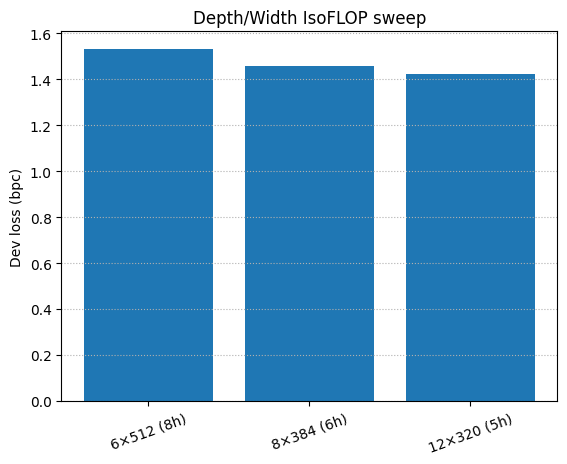

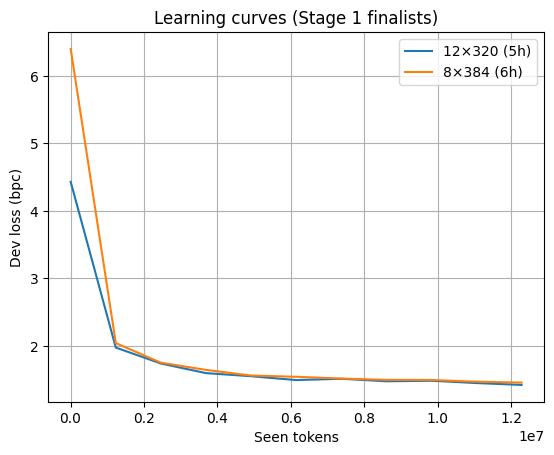


Stage 2 (heads) results:
    layers  d_model  n_heads  d_head  num_params  dev_loss_last  dev_acc_last
1      12      320        5      64    14839040       1.444408      0.555664
0      12      320        2     160    14839040       1.479821      0.580078


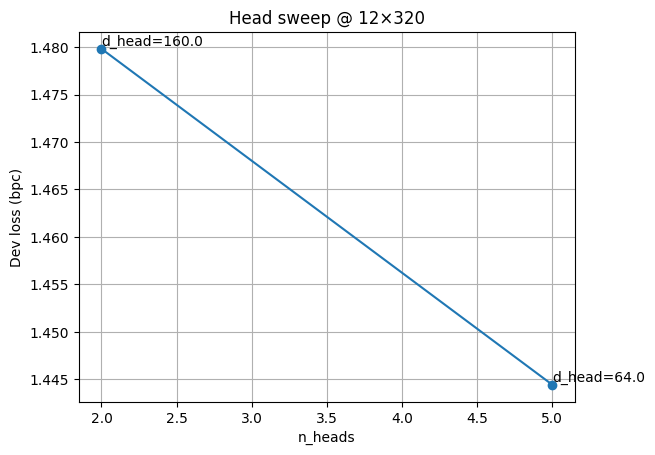


Stage 3 (width) results:
    layers  d_model  n_heads  d_head  num_params  dev_loss_last  dev_acc_last
1      12      320        5      64    14839040       1.433364      0.559570
2      12      352        4      88    17944960       1.448908      0.590820
0      12      288        4      72    12028032       1.456681      0.583984


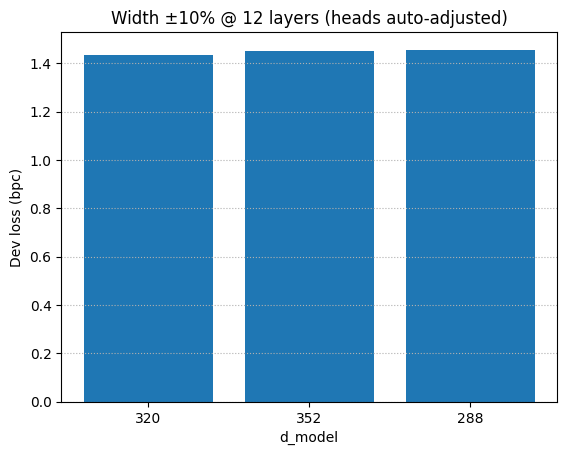

In [34]:
import pandas as pd
import matplotlib.pyplot as plt

def results_df(results):
    rows = []
    for r in results:
        rows.append({
            "layers": r["n_layers"], "d_model": r["d_model"], "n_heads": r["n_heads"],
            "d_head": r["d_head"], "num_params": r["num_params"],
            "dev_loss_last": r["dev_loss_last"], "dev_acc_last": r["dev_acc_last"]
        })

    return pd.DataFrame(rows).sort_values("dev_loss_last")

# ---- Stage 1 plot: IsoFLOP frontier ----
df1 = results_df(results_stage1)
print("\nStage 1 results:\n", df1)

plt.figure()
labels = [f'{r["n_layers"]}×{r["d_model"]} ({r["n_heads"]}h)'
          for r in results_stage1]
vals   = [r["dev_loss_last"] for r in results_stage1]
plt.bar(labels, vals)
plt.ylabel("Dev loss (bpc)")
plt.title("Depth/Width IsoFLOP sweep")
plt.xticks(rotation=20); plt.grid(axis="y", linestyle=":")
plt.show()

# ---- Learning curves for top-2 from Stage 1 ----
top2 = sorted(results_stage1, key=lambda r: r["dev_loss_last"])[:2]
plt.figure()
for r in top2:
    xs = [t[0] for t in r["curve"]]
    ys = [t[2] for t in r["curve"]]
    plt.plot(xs, ys, label=f'{r["n_layers"]}×{r["d_model"]} ({r["n_heads"]}h)')
plt.xlabel("Seen tokens"); plt.ylabel("Dev loss (bpc)")
plt.title("Learning curves (Stage 1 finalists)")
plt.legend(); plt.grid(True); plt.show()

# ---- Stage 2 plot: head sensitivity ----
df2 = results_df(results_heads)
print("\nStage 2 (heads) results:\n", df2)

plt.figure()
plt.plot(df2["n_heads"], df2["dev_loss_last"], marker="o")
for _, row in df2.iterrows():
    plt.text(row["n_heads"], row["dev_loss_last"], f'd_head={row["d_head"]}',
             ha="left", va="bottom")
plt.xlabel("n_heads"); plt.ylabel("Dev loss (bpc)")
plt.title(f'Head sweep @ {base_layers}×{base_d_model}')
plt.grid(True); plt.show()

# ---- Stage 3 plot: width micro-sweep ----
df3 = results_df(results_width)
print("\nStage 3 (width) results:\n", df3)

plt.figure()
plt.bar([str(d) for d in df3["d_model"]], df3["dev_loss_last"])
plt.xlabel("d_model"); plt.ylabel("Dev loss (bpc)")
plt.title(f'Width ±10% @ {base_layers} layers (heads auto-adjusted)')
plt.grid(axis="y", linestyle=":"); plt.show()


# Full Final Run

In [35]:
# # ===== FINAL FULL TRAIN on chosen config; then TEST & GENERATE =====
# best_layers = final_pilot["n_layers"]
# best_dmodel = final_pilot["d_model"]
# best_heads  = final_pilot["n_heads"]

# print(f"\n>>> Training final model: layers={best_layers}, d_model={best_dmodel}, heads={best_heads}")
# key = jax.random.key(123)
# model, params = create_train_state(key, vocab_size, best_dmodel, best_layers, best_heads, max_len=128)
# tx = optax.adam(learning_rate=1e-3)
# opt_state = tx.init(params)

# niter_full = 100_000  # your full budget
# B, T = 128, 32

# for it in range(niter_full):
#     x, y = get_batch_ids(train_ids, B, T)
#     params, opt_state, metrics = train_step(params, opt_state, x, y, tx)
#     if it % max(1, niter_full//50) == 0 or it == niter_full-1:
#         xd, yd = get_batch_ids(dev_ids, 1024, T)
#         logits = model.apply({"params": params}, xd)
#         dev_loss, dev_metrics = loss_and_metrics(logits, yd)
#         print(f"it {it:_}  train_loss={float(metrics['loss']):.4f}  dev_loss={float(dev_loss):.4f}  dev_acc_last={float(dev_metrics['acc_last']):.4f}")

# # ---- Final evaluation on TEST (only now) ----
# xt, yt = get_batch_ids(test_text_int, 4096, T)
# test_logits = model.apply({"params": params}, xt)
# test_loss, test_metrics = loss_and_metrics(test_logits, yt)
# print(f"\nTEST: loss={float(test_loss):.4f}  acc={float(test_metrics['acc']):.4f}  acc_last={float(test_metrics['acc_last']):.4f}")

# # ---- Generation demo ----
# seed = 42
# rng = jax.random.PRNGKey(seed)
# prompt = "hello my fri"
# prompt_int = jnp.array([[char_to_int.get(c, len(char_set)) for c in prompt.lower()[:64]]], dtype=jnp.int32)
# gen_len = 300
# out_ids = generation.generate_tokens(model, params, rng, prompt_int, gen_len, block_size=64,
#                                      temperature=0.7, sample=True)
# generated_text = ''.join(int_to_char.get(int(x), '?') for x in list(out_ids[0]))
# print("\nGenerated text:\n", prompt + generated_text)
